# Prédire si le rendement d'un panneau solaire est optimal en fonction de la météo

Le but est d'étudier le rendement de nos panneaux solaires en fonction de la météo. Pour cela, familarisons nous avec le panneau solaire. 

## Import des librairies

In [486]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier



import warnings
warnings.filterwarnings("ignore")

## Import de nos données et preprocessing

Pour cette exercice, certaine contraintes ont été imposé:
- Une taille de dataset de 15 colonnes

### Import des données de l'installation 1

In [404]:
plant1_machine = pd.read_csv('data/Plant_1_Generation_Data.csv')

In [405]:
plant1_machine.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [406]:
plant1_machine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


Dans le dataset de base, on trouve 7 données :
- DATE_TIME qui est la date de la mesure
- PLANT_ID qui l'id de l'installation
- SOURCE_KEY qui est l'id du panneau solaire
- DC_Power qui est la puissance du courant continue
- AC_POWER qui est la puissance du courant alternatif généré
- DAILY_YIELD qui est le rendement de la machine
- TOTAL_YIELD qui est le total du rendement de la machine depuis ça mise en marche

#### Transformation de la date

In [407]:
plant1_machine['DATE_TIME'] = pd.to_datetime(plant1_machine['DATE_TIME'])
plant1_machine['TIME'] = plant1_machine['DATE_TIME'].dt.time

#### Nombre d'onduleur

In [408]:
plant1_machine["SOURCE_KEY"].unique().size

22

### Merge avec les données météo

In [409]:
plant1_weather = pd.read_csv('data/Plant_1_Weather_Sensor_Data.csv')
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather['DATE_TIME'])

plant1_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [410]:
plant1_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


In [411]:
plant1 = pd.merge(plant1_machine,plant1_weather[["DATE_TIME","SOURCE_KEY","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION"]],on = ['DATE_TIME'] ,how='left')
plant1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,00:00:00,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


### Rendre Explicite les données et en ajouter d'autre

In [412]:
plant1["INVERTER_ID"] = plant1["SOURCE_KEY_x"]
plant1 = plant1.drop("SOURCE_KEY_x",1)

plant1["WEATHER_SENSOR_ID"] = plant1["SOURCE_KEY_y"]
plant1 = plant1.drop("SOURCE_KEY_y",1)

plant1 = plant1.dropna()

#### Rapport entre le DC et l'IRRADIATION

In [413]:
plant1['RAPPORT_DC_IRRADIATION'] = plant1['DC_POWER'] / plant1['IRRADIATION']

#### Delta entre la température de la machine et la température exterieure

In [414]:
plant1['DELTA_TEMPERATURE'] = plant1['MODULE_TEMPERATURE'] - plant1['AMBIENT_TEMPERATURE']

#### Delta entre le DC et l'AC

In [415]:
plant1['DELTA_COURANT'] = plant1['DC_POWER'] - plant1['AC_POWER']

In [416]:
plant1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 68777
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE_TIME               45680 non-null  datetime64[ns]
 1   PLANT_ID                45680 non-null  int64         
 2   DC_POWER                45680 non-null  float64       
 3   AC_POWER                45680 non-null  float64       
 4   DAILY_YIELD             45680 non-null  float64       
 5   TOTAL_YIELD             45680 non-null  float64       
 6   TIME                    45680 non-null  object        
 7   AMBIENT_TEMPERATURE     45680 non-null  float64       
 8   MODULE_TEMPERATURE      45680 non-null  float64       
 9   IRRADIATION             45680 non-null  float64       
 10  INVERTER_ID             45680 non-null  object        
 11  WEATHER_SENSOR_ID       45680 non-null  object        
 12  RAPPORT_DC_IRRADIATION  25692 non-null  float6

### Données optimals

In [417]:
def DC_POWER_efficiency(DC_POWER):
    if DC_POWER > 800 :
        return 1
    return 0

In [418]:
def AMBIENT_TEMPERATURE_efficiency(AMBIENT_TEMPERATURE):
    if AMBIENT_TEMPERATURE > 20 and AMBIENT_TEMPERATURE < 30 :
        return 1
    return 0

In [419]:
def IRRADIATION_efficiency(IRRADIATION):
    if IRRADIATION > 0.4 :
        return 1
    return 0

In [420]:
def EFFICIENCY_calculation(row):
    if AMBIENT_TEMPERATURE_efficiency(row['AMBIENT_TEMPERATURE']) and DC_POWER_efficiency(row['DC_POWER']) and IRRADIATION_efficiency(row['IRRADIATION']):
        return "OK"
    return "NOK"

In [421]:
plant1["EFFICIENCY"] = plant1.apply(EFFICIENCY_calculation, axis=1)

In [422]:
labelencoder = preprocessing.LabelEncoder()
plant1['EFFICIENCY_num'] = labelencoder.fit_transform(plant1['EFFICIENCY'])

In [423]:
plant1.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INVERTER_ID,WEATHER_SENSOR_ID,RAPPORT_DC_IRRADIATION,DELTA_TEMPERATURE,DELTA_COURANT,EFFICIENCY,EFFICIENCY_num
0,2020-05-15,4135001,0.0,0.0,0.0,6259559.0,00:00:00,25.184316,22.857507,0.0,1BY6WEcLGh8j5v7,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
1,2020-05-15,4135001,0.0,0.0,0.0,6183645.0,00:00:00,25.184316,22.857507,0.0,1IF53ai7Xc0U56Y,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
2,2020-05-15,4135001,0.0,0.0,0.0,6987759.0,00:00:00,25.184316,22.857507,0.0,3PZuoBAID5Wc2HD,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
3,2020-05-15,4135001,0.0,0.0,0.0,7602960.0,00:00:00,25.184316,22.857507,0.0,7JYdWkrLSPkdwr4,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
4,2020-05-15,4135001,0.0,0.0,0.0,7158964.0,00:00:00,25.184316,22.857507,0.0,McdE0feGgRqW7Ca,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0


## Analyse des données

Prenons le cas du module d'id '1BY6WEcLGh8j5v7' 

In [424]:
plant1_1BY6WEcLGh8j5v7 = plant1.query("INVERTER_ID == '1BY6WEcLGh8j5v7'")

### Que ce passe-t-il en journée?

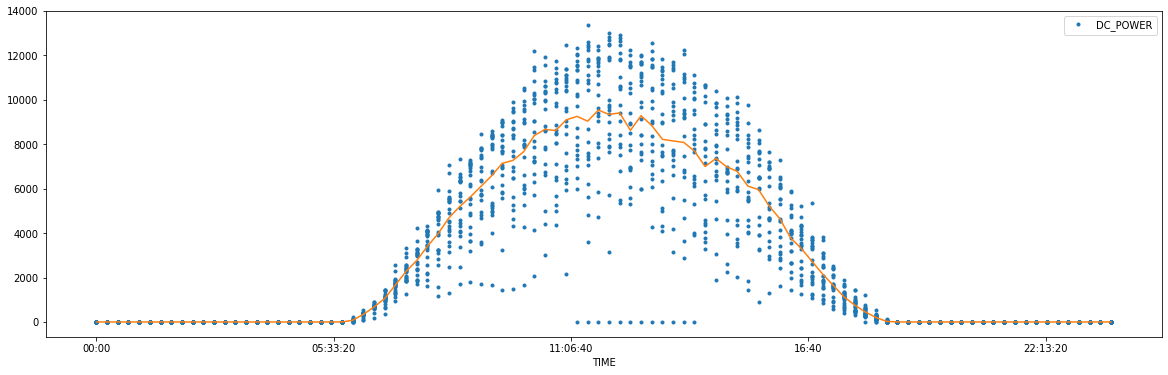

In [425]:
plant1_1BY6WEcLGh8j5v7.plot(x='TIME', y='DC_POWER', style='.')
plant1_1BY6WEcLGh8j5v7.groupby('TIME')['DC_POWER'].mean().plot(x='TIME', y='DC_POWER')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

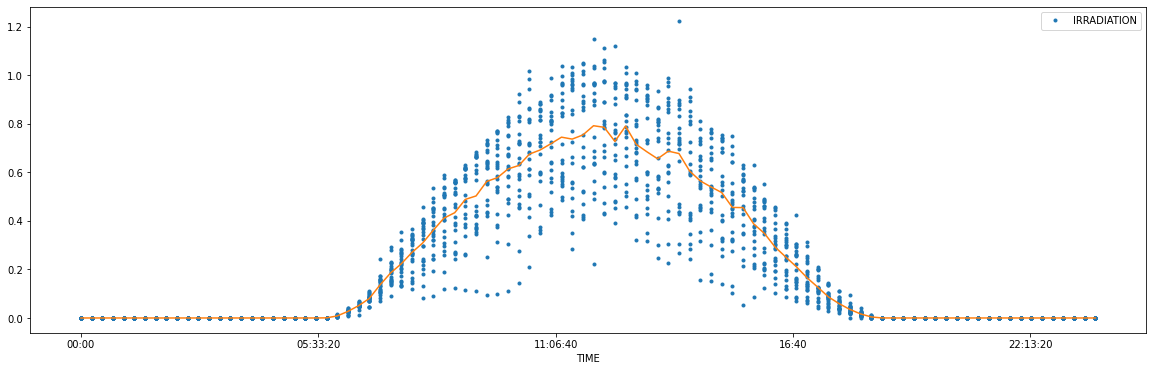

In [426]:
plant1_1BY6WEcLGh8j5v7.query("INVERTER_ID == '1BY6WEcLGh8j5v7'").plot(x='TIME', y='IRRADIATION', style='.')
plant1_1BY6WEcLGh8j5v7.groupby('TIME')['IRRADIATION'].mean().plot(x='TIME', y='IRRADIATION')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

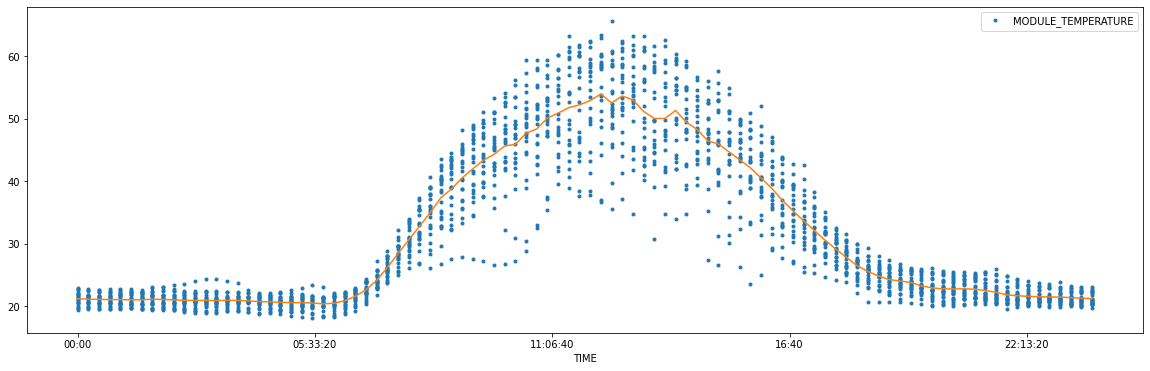

In [427]:
plant1_1BY6WEcLGh8j5v7.plot(x='TIME', y='MODULE_TEMPERATURE', style='.')
plant1_1BY6WEcLGh8j5v7.groupby('TIME')['MODULE_TEMPERATURE'].mean().plot(x='TIME', y='MODULE_TEMPERATURE')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### Que ce passe-t-il sur la période?

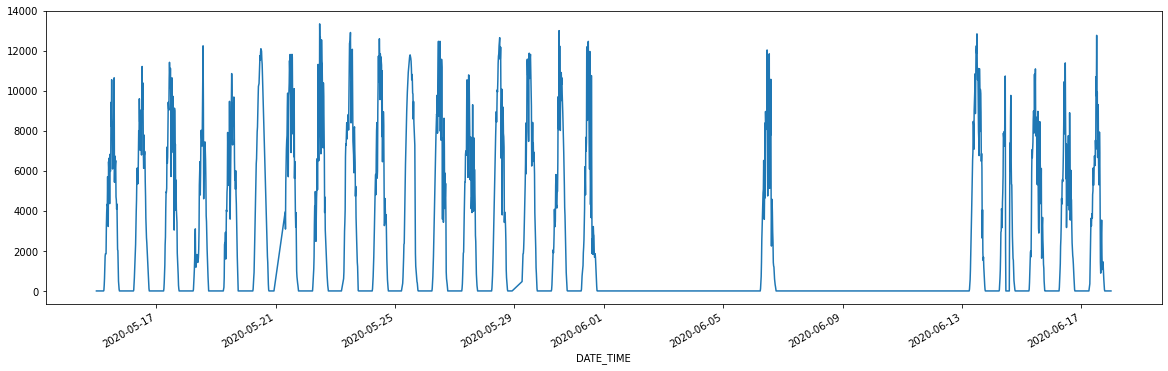

In [428]:
plant1_1BY6WEcLGh8j5v7.groupby('DATE_TIME')['DC_POWER'].mean().plot(x='TIME', y='DC_POWER')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

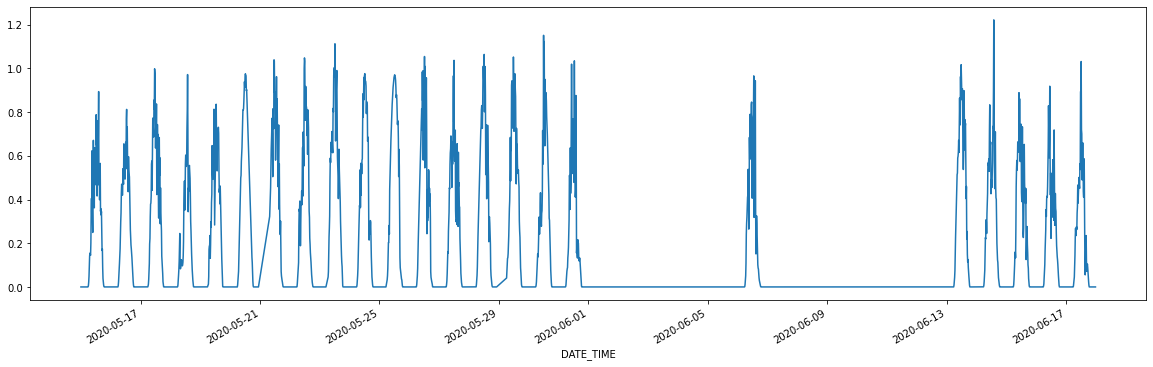

In [429]:
plant1_1BY6WEcLGh8j5v7.groupby('DATE_TIME')['IRRADIATION'].mean().plot(x='TIME', y='IRRADIATION')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

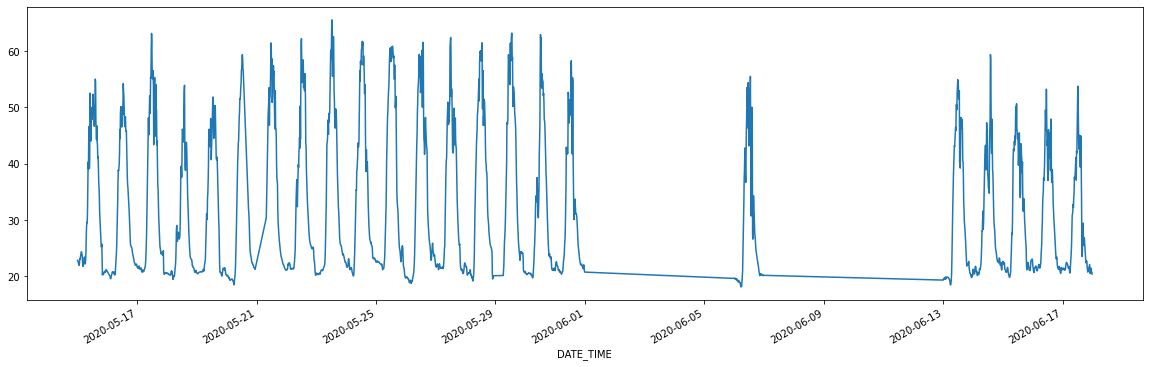

In [430]:
plant1_1BY6WEcLGh8j5v7.groupby('DATE_TIME')['MODULE_TEMPERATURE'].mean().plot(x='DATE_TIME', y='MODULE_TEMPERATURE')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### Que ce passe-t-il pour une date donnée (25/05/2020)?

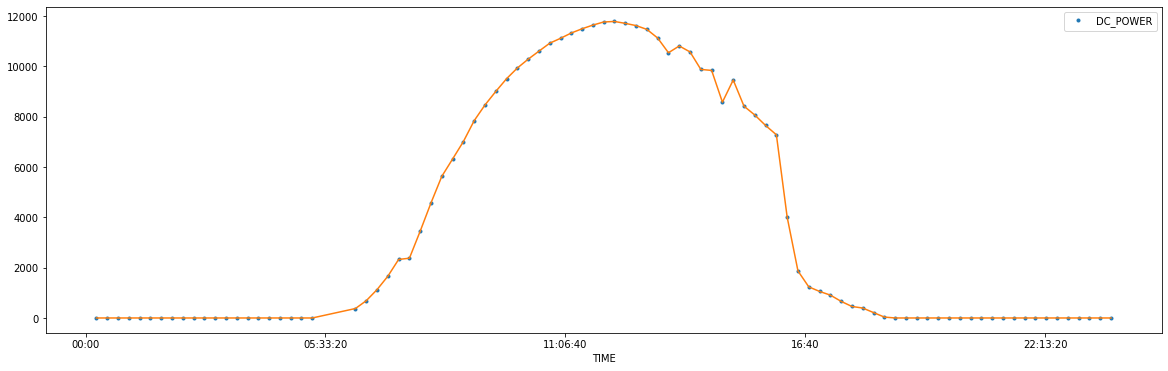

In [431]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").plot(x='TIME', y='DC_POWER', style='.')
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['DC_POWER'].mean().plot(x='TIME', y='DC_POWER')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

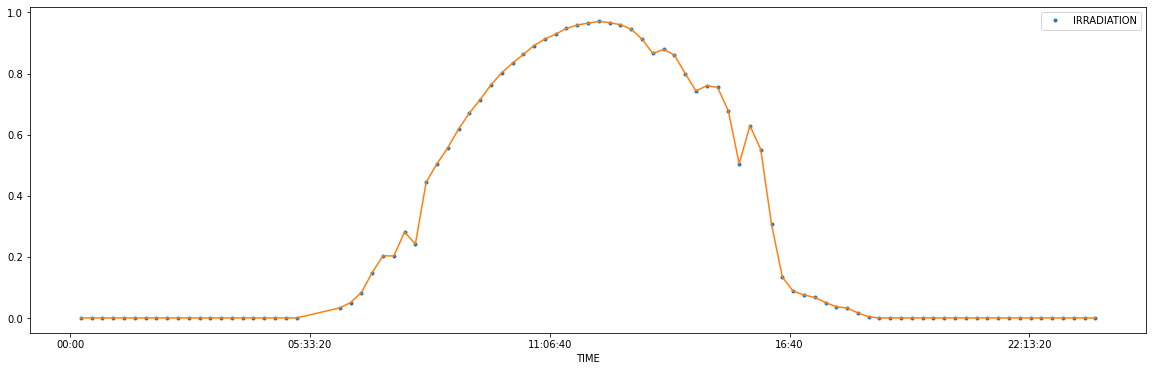

In [432]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").plot(x='TIME', y='IRRADIATION', style='.')
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['IRRADIATION'].mean().plot(x='TIME', y='IRRADIATION')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

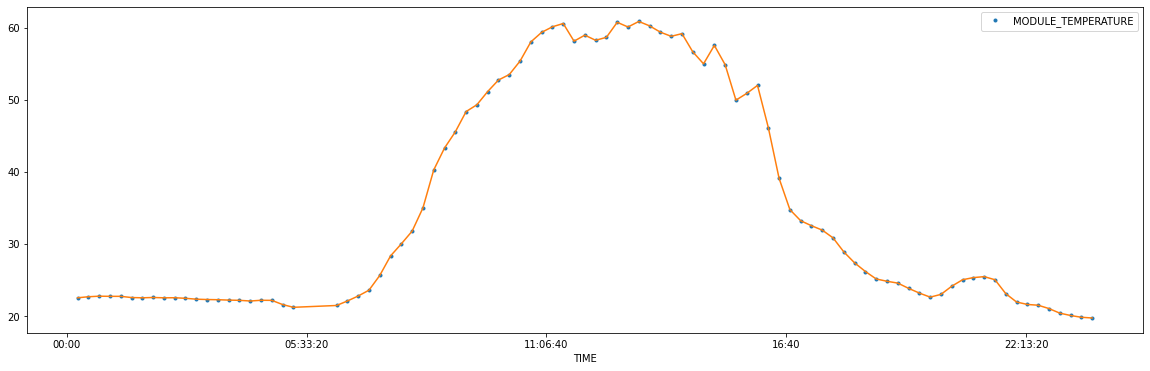

In [433]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").plot(x='TIME', y='MODULE_TEMPERATURE', style='.')
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['MODULE_TEMPERATURE'].mean().plot(x='TIME', y='MODULE_TEMPERATURE')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### Ya-t-il coorélation entre le delta du courant et la température?

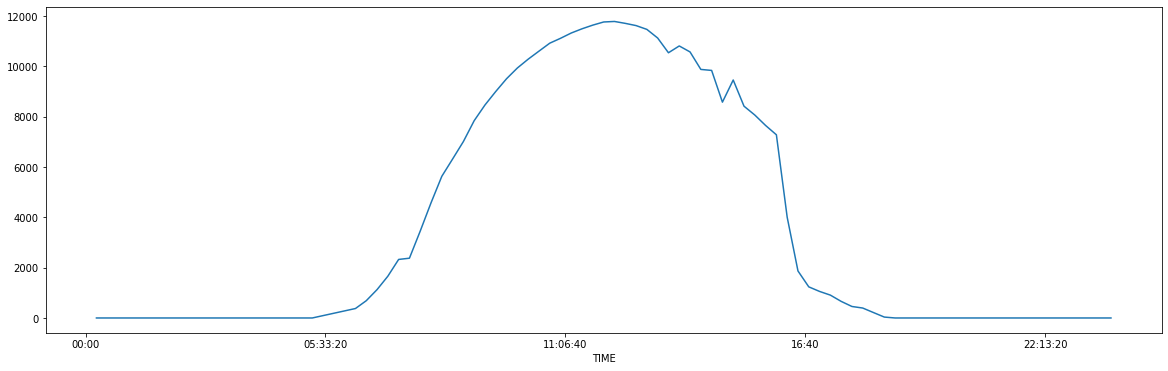

In [434]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['DC_POWER'].mean().plot(x='TIME', y='DC_POWER')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

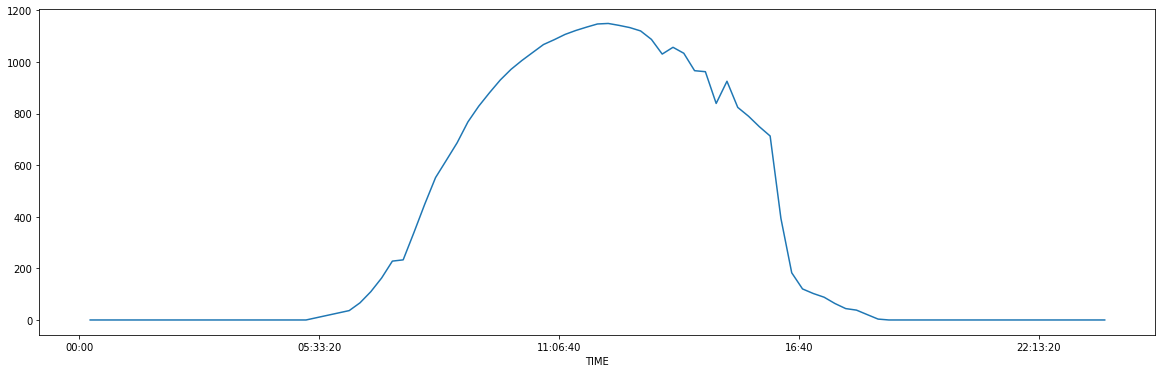

In [435]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['AC_POWER'].mean().plot(x='TIME', y='AC_POWER')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

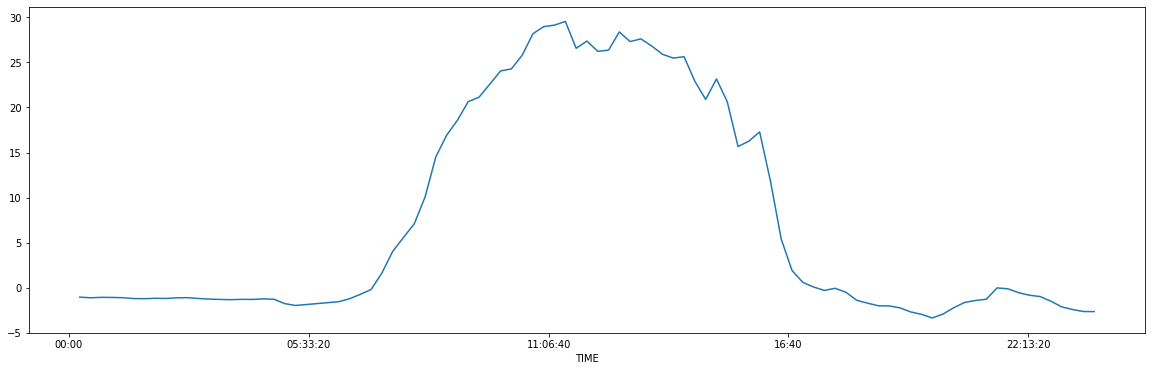

In [436]:
plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-05-26 00:00'").groupby('TIME')['DELTA_TEMPERATURE'].mean().plot(x='TIME', y='DELTA_TEMPERATURE')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### Restriction de la période

In [437]:
plant1_1BY6WEcLGh8j5v7_filtrer = plant1_1BY6WEcLGh8j5v7.query(" DATE_TIME > '2020-05-25 00:00' and DATE_TIME < '2020-06-01 00:00'")

## Ce que l'on sait :

### Une température peux faire varier le DC produit

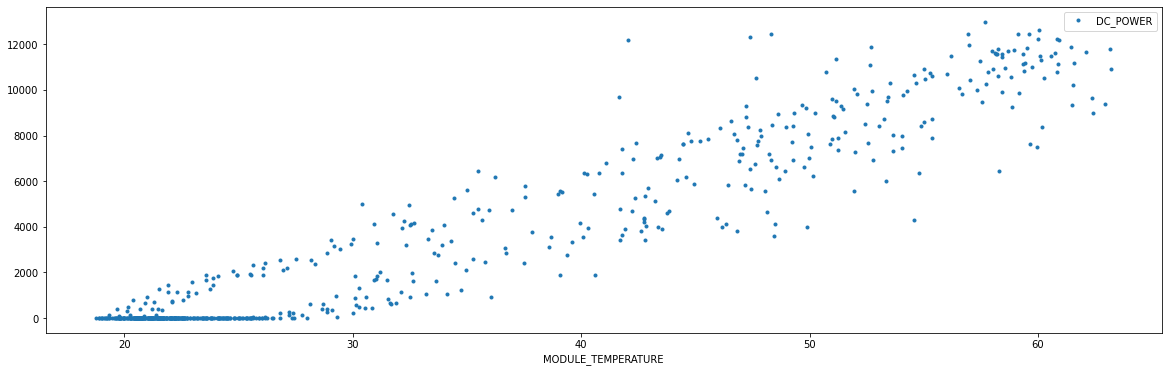

In [438]:
plant1_1BY6WEcLGh8j5v7_filtrer.plot(x='MODULE_TEMPERATURE', y='DC_POWER', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### La luminosité peux faire varier le DC

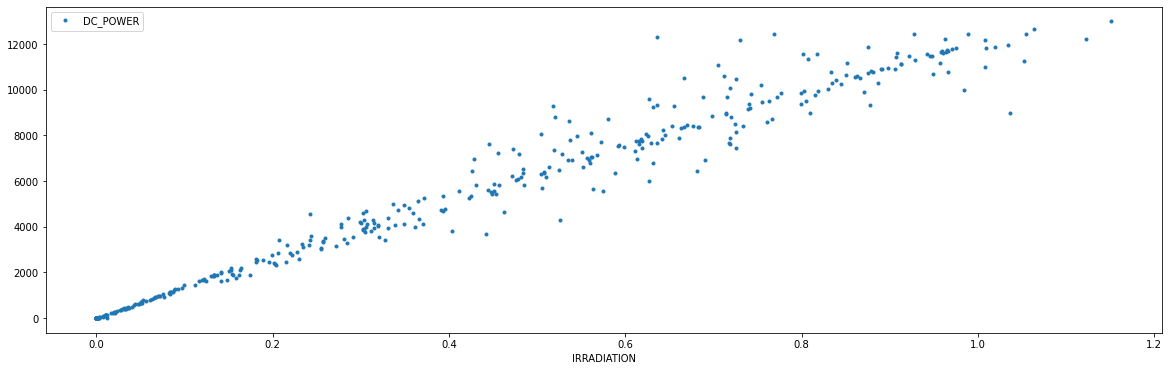

In [439]:
plant1_1BY6WEcLGh8j5v7_filtrer.plot(x='IRRADIATION', y='DC_POWER', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

### Données en fonction de l'EFFICIENCY

In [440]:
vocabulaire = plant1_1BY6WEcLGh8j5v7_filtrer['EFFICIENCY'].astype('category').cat.categories

#Ici, on vas créer un dictionnaire qui prendra v qui est l'espèce et lui associera la nombre de fois qu'il apparait dans notre dataframe 
ListEFFICIENCY = {v:plant1_1BY6WEcLGh8j5v7_filtrer.query("EFFICIENCY == '" + v + "'")['EFFICIENCY'].count() for i,v in enumerate(vocabulaire.tolist())}

In [441]:
NBEFFICIENCY = []
for k,v in ListEFFICIENCY.items():
    NBEFFICIENCY.append(v)
NBEFFICIENCY

[547, 89]

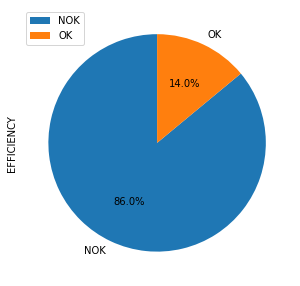

In [442]:
Data = {'EFFICIENCY': NBEFFICIENCY}
df = pd.DataFrame(Data,columns=['EFFICIENCY'],index = list(ListEFFICIENCY))

df.plot.pie(y='EFFICIENCY',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

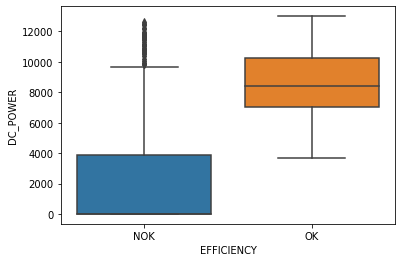

In [443]:
g = sns.boxplot(x="EFFICIENCY", y="DC_POWER", data=plant1_1BY6WEcLGh8j5v7_filtrer)

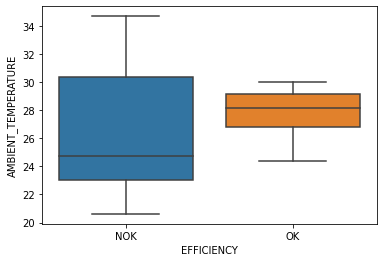

In [444]:
g = sns.boxplot(x="EFFICIENCY", y="AMBIENT_TEMPERATURE", data=plant1_1BY6WEcLGh8j5v7_filtrer)

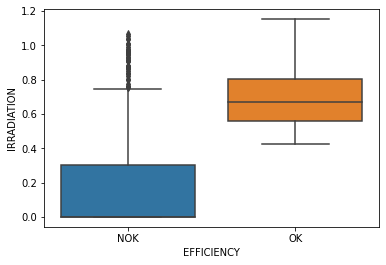

In [445]:
g = sns.boxplot(x="EFFICIENCY", y="IRRADIATION", data=plant1_1BY6WEcLGh8j5v7_filtrer)

### Coorélation entre la target (DC_POWER) et la features

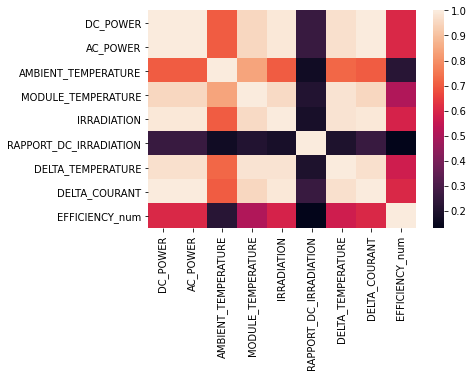

In [446]:
g = sns.heatmap(plant1.drop(columns=['DAILY_YIELD', 'TOTAL_YIELD','PLANT_ID']).corr())

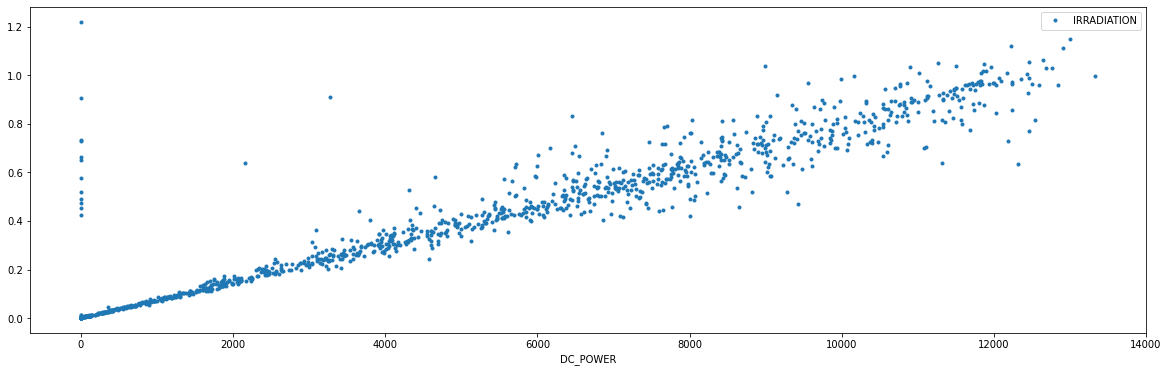

In [447]:
plant1_1BY6WEcLGh8j5v7.plot(x='DC_POWER', y='IRRADIATION', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

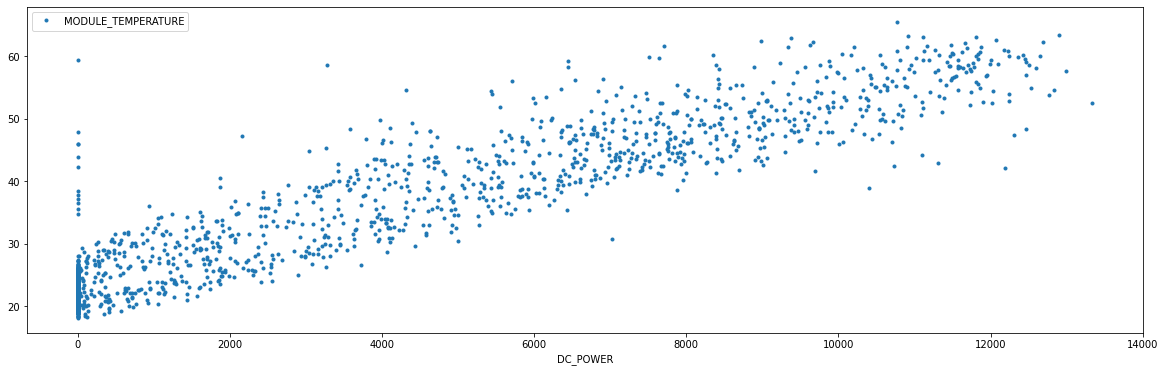

In [448]:
plant1_1BY6WEcLGh8j5v7.plot(x='DC_POWER', y='MODULE_TEMPERATURE', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

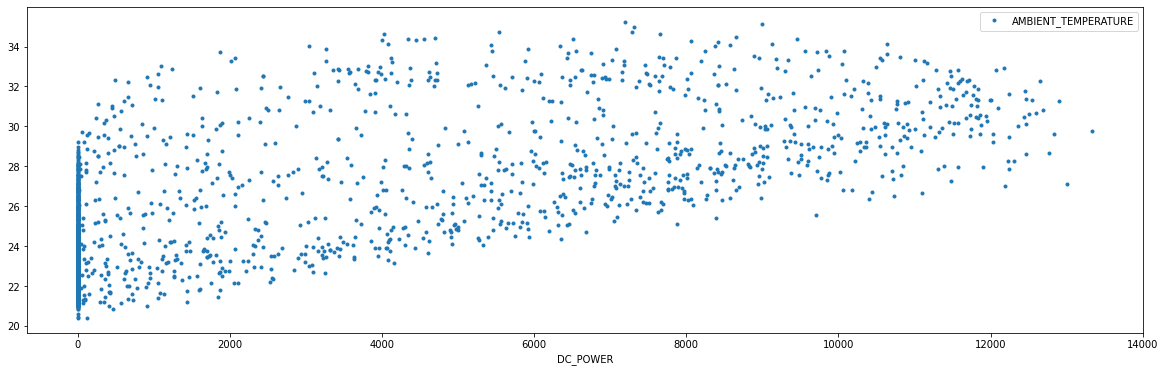

In [449]:
plant1_1BY6WEcLGh8j5v7.plot(x='DC_POWER', y='AMBIENT_TEMPERATURE', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

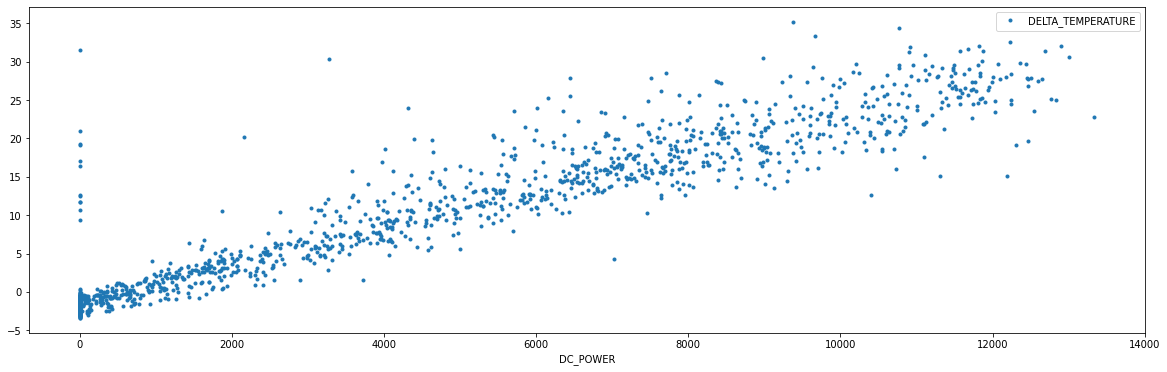

In [450]:
plant1_1BY6WEcLGh8j5v7.plot(x='DC_POWER', y='DELTA_TEMPERATURE', style='.')
fig = mp.pyplot.gcf()
fig.set_size_inches(20,6)

## Entrainement de model et test (Pour la classification [target = EFFICIENCY])

In [451]:
plant1.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INVERTER_ID,WEATHER_SENSOR_ID,RAPPORT_DC_IRRADIATION,DELTA_TEMPERATURE,DELTA_COURANT,EFFICIENCY,EFFICIENCY_num
0,2020-05-15,4135001,0.0,0.0,0.0,6259559.0,00:00:00,25.184316,22.857507,0.0,1BY6WEcLGh8j5v7,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
1,2020-05-15,4135001,0.0,0.0,0.0,6183645.0,00:00:00,25.184316,22.857507,0.0,1IF53ai7Xc0U56Y,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
2,2020-05-15,4135001,0.0,0.0,0.0,6987759.0,00:00:00,25.184316,22.857507,0.0,3PZuoBAID5Wc2HD,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
3,2020-05-15,4135001,0.0,0.0,0.0,7602960.0,00:00:00,25.184316,22.857507,0.0,7JYdWkrLSPkdwr4,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0
4,2020-05-15,4135001,0.0,0.0,0.0,7158964.0,00:00:00,25.184316,22.857507,0.0,McdE0feGgRqW7Ca,HmiyD2TTLFNqkNe,NaN,-2.326809,0.0,NOK,0


In [452]:
X = plant1.drop(["DATE_TIME","PLANT_ID","AC_POWER","DAILY_YIELD","TOTAL_YIELD","TIME","INVERTER_ID","WEATHER_SENSOR_ID","RAPPORT_DC_IRRADIATION","DELTA_COURANT","EFFICIENCY","EFFICIENCY_num"], axis='columns')
Y = plant1['EFFICIENCY'].astype('category')

In [453]:
X.shape , Y.shape

((45680, 5), (45680,))

In [454]:
X.head()

,DC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DELTA_TEMPERATURE
0,0.0,25.184316,22.857507,0.0,-2.326809
1,0.0,25.184316,22.857507,0.0,-2.326809
2,0.0,25.184316,22.857507,0.0,-2.326809
3,0.0,25.184316,22.857507,0.0,-2.326809
4,0.0,25.184316,22.857507,0.0,-2.326809


In [455]:
Y.head()

0    NOK
1    NOK
2    NOK
3    NOK
4    NOK
Name: EFFICIENCY, dtype: category
Categories (2, object): ['NOK', 'OK']

In [456]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3, stratify=Y,random_state=2)

In [457]:
def pipeline(X_train_data, X_test_data, y_train_data, y_test_data,model, param_grid):
    
    gridSearch = GridSearchCV(estimator=model,param_grid=param_grid, cv=5, scoring='accuracy')
    modelTrain = gridSearch.fit(X_train_data, y_train_data)
    pred = modelTrain.predict(X_test_data)
    
    return modelTrain, pred

In [458]:
classes = Y.astype('category').cat.categories.tolist()

In [459]:
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [460]:
def show_roc(model,X_test,Y_test) :
    metrics.plot_roc_curve(model, X_test, Y_test)
    plt.show()  

In [461]:
def arrayToPourcentage(cm, labels):
    al = []
    for row in cm_train:
        row2 = []
        for value in row:
            val = value/len(Y_test) * 100
            row2.append(val)
        print(row2)    
        al.append(row2)        

    return np.array(al)

In [468]:
def show_featuresImportance(X_train,feature_importances) :
    
    d = pd.DataFrame()
    d['features'] = X_train.columns
    d['pouvoir_predictif'] = feature_importances

    print('Somme des pouvoirs predictif : {}'.format(d['pouvoir_predictif'].sum()))

    d['pouvoir_predictif'] = d['pouvoir_predictif'].apply(lambda v : v*100)
    d = d.sort_values(by='pouvoir_predictif', ascending=True)
    sns.barplot(d['pouvoir_predictif'], d['features']).set_title('Pouvoir predictif des features');

### KNN

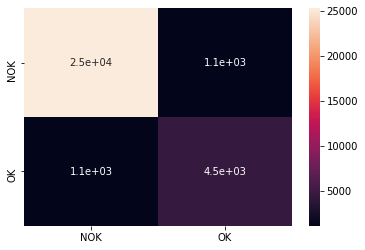

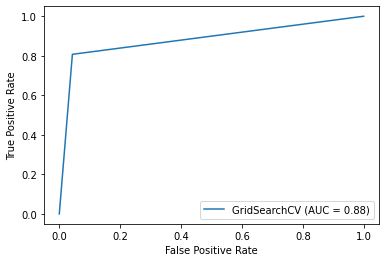

0.9178339728960341
{'n_neighbors': 1}


In [480]:

param_grid = {
              'n_neighbors':[1, 3, 5, 9, 21]
             }

model = KNN()
model, Y_pred = pipeline(X_train, X_test, Y_train, Y_test, model,param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, X_test, Y_test)

print(model.best_score_)
print(model.best_params_)

### RandomForest

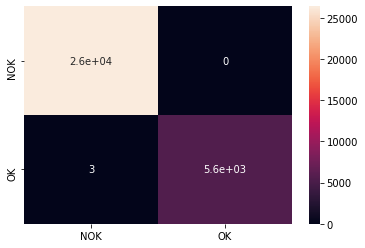

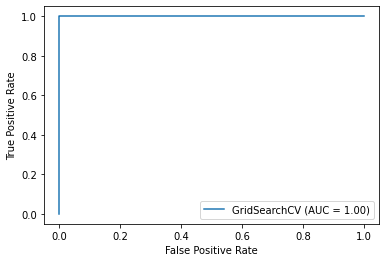

Somme des pouvoirs predictif : 1.0
0.9998540678584458
{'random_state': 200}


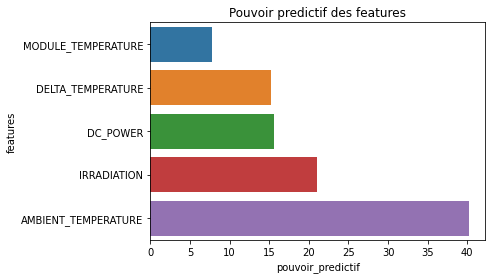

In [482]:

param_grid = {
              'random_state':[100, 200, 300, 400, 500]
             }

model = RandomForestClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, Y_test, model,param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, X_test, Y_test)

show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)


### DecisionTree

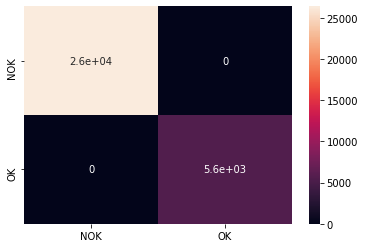

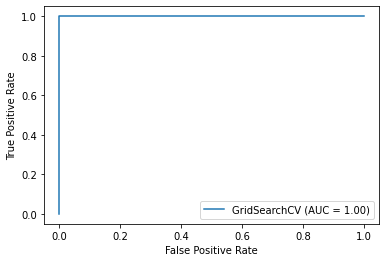

Somme des pouvoirs predictif : 1.0
1.0
{'max_depth': 3}


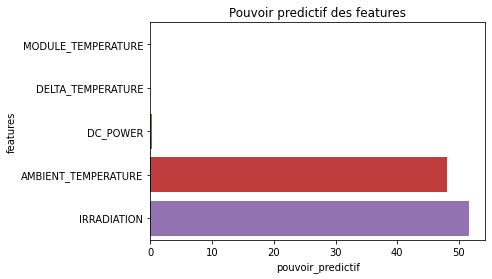

In [483]:

param_grid = {
              'max_depth':[1, 2, 3, 4, 5]
             }

model = DecisionTreeClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, Y_test, model,param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, X_test, Y_test)

show_featuresImportance(X_train,model.best_estimator_.feature_importances_)

print(model.best_score_)
print(model.best_params_)

### SVC

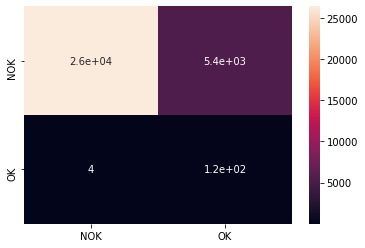

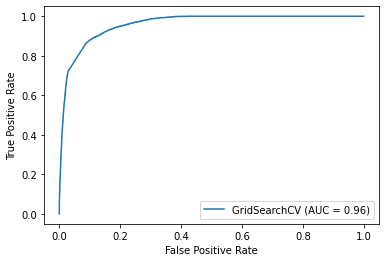

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [484]:

param_grid = {
              'gamma':[1,2],
              'C':[1]
             }

model = SVC()
model, Y_pred = pipeline(X_train, X_test, Y_train, Y_test, model,param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, X_test, Y_test)

print(model.best_score_)
print(model.best_params_)

### AdaBoostClassifier

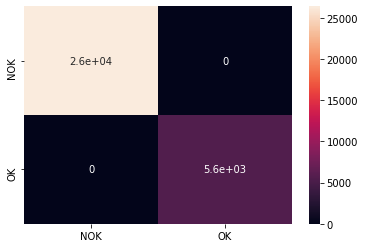

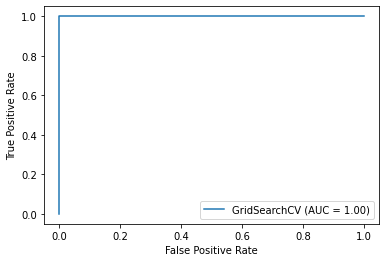

Somme des pouvoirs predictif : 1.0
1.0
{'n_estimators': 10, 'random_state': 1}


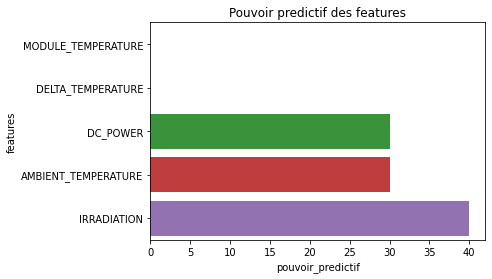

In [485]:

param_grid = {
              'n_estimators':[10,20],
              'random_state':[1,2,3]
             }

model = AdaBoostClassifier()
model, Y_pred = pipeline(X_train, X_test, Y_train, Y_test, model,param_grid)

cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

show_roc(model, X_test, Y_test)

show_featuresImportance(X_train,model.best_estimator_.feature_importances_)


print(model.best_score_)
print(model.best_params_)

In [ ]:
plant1['EFFICIENCY']

In [ ]:
classes = plant1['EFFICIENCY'].astype('category').cat.categories.tolist()

In [ ]:
classes = Y.astype('category').cat.categories.tolist()

In [ ]:
classes

In [ ]:
from sklearn.metrics import confusion_matrix
def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

In [ ]:
cm_train = confusion_matrix(Y_pred, Y_test, labels=classes)
show_cm(cm_train, classes)

In [ ]:
print(len(Y_test))
al = []
for row in cm_train:
    row2 = []
    for value in row:
        val = value/len(Y_test) * 100
        row2.append(val)
    print(row2)    
    al.append(row2)        

cm_train2 = np.array(al)
cm_train = cm_train2

In [ ]:
show_cm(cm_train, classes)
#Accuracy du training
accuracy = lambda p, y : (p==y).sum()/len(y)
print('Accuracy : {}'.format(accuracy(Y_pred, Y_test)))

## ROC

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

accuracy(Y_pred,Y_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
Y_pred

In [ ]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
y_pred = Y_pred[:, 1]  
fper, tper, thresholds = roc_curve(aa, aa) 
plot_roc_curve(fper, tper)


In [ ]:
pip install scikit-plot

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(plant1_1BY6WEcLGh8j5v7, title="Data Anime", html={'style' : {'full_width': True}})
profile.to_notebook_iframe()